# 32x32 expGP image reconstruction

Image reconstruction.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils.ns import SwyftSimpleSliceSampler
from swyft.lightning.estimators import LogRatioEstimator_Autoregressive, LogRatioEstimator_Gaussian, LogRatioEstimator_Autoregressive_Gaussian

import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [15]:
Npix = 32
N = Npix**2

l = torch.arange(Npix)
L1, L2 = torch.meshgrid(l, l)
L = torch.stack([L1, L2], dim = -1)
T = L.unsqueeze(0).unsqueeze(0) - L.unsqueeze(2).unsqueeze(2)
T = (T**2).sum(-1)**0.5
T = T.view(N, N)
Cov = torch.exp(-T/16)*0.5 + torch.exp(-T/8)*.25 + torch.exp(-T/4)*.125

dist = torch.distributions.MultivariateNormal(torch.zeros(N), Cov)

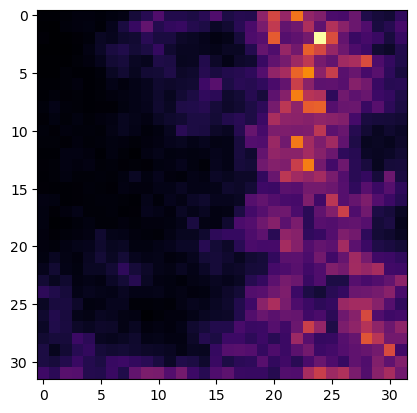

In [21]:
def sample_GP(N, gamma = 3):
    #z = np.random.multivariate_normal(np.zeros(N), Cov.numpy()).reshape(Npix, Npix)
    z = dist.sample(torch.Size([1]))[0].numpy().reshape(Npix, Npix)
    return z

z = sample_GP(N, gamma = 2.5)
plt.imshow(np.exp(z), cmap='inferno')

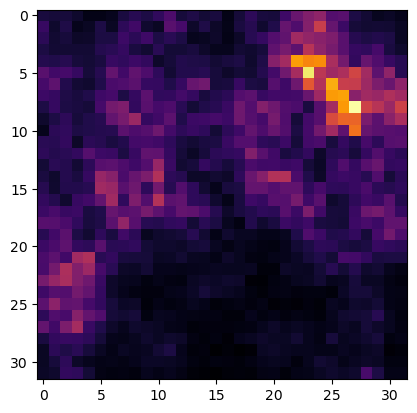

In [22]:
class Sim(swyft.Simulator):
    def __init__(self, sigma = .1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sigma = sigma    
  
    def build(self, graph):
        z = graph.node("z", lambda: sample_GP(N, gamma = 2.5))
        y = graph.node("y", lambda z: np.exp(z), z)
        x = graph.node("x", lambda y: y + np.random.randn(Npix, Npix)*self.sigma, y)
        
        
sim = Sim()
s = sim.sample()
plt.imshow(s['x'], cmap='inferno')

In [46]:
class Network(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = 100):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.1, lrs_patience=3)
        self.num_params = D
        self.lre = LogRatioEstimator_Autoregressive_Gaussian(D, "mu")
        self.l = nn.Sequential(
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.LazyLinear(1)
        )

    def forward(self, A, B):
        x = A["x"].view(-1, N)
        f = self.l(x.unsqueeze(-1)).squeeze(-1)
        result = self.lre(f, A['z'].view(-1,N), B['z'].view(-1, N))
        return result

In [47]:
sim = Sim()
samples = sim.sample(10000)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 64)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [48]:
net = Network(D=N)

In [49]:
net.lre._momentum = 0.01

In [50]:
trainer = swyft.SwyftTrainer(accelerator = "cpu", devices = 1, max_epochs = 50)
trainer.fit(net, dm)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type                                      | Params
-------------------------------------------------------------------
0 | lre  | LogRatioEstimator_Autoregressive_Gaussian | 3.1 M 
1 | l    | Sequential                                | 0     
-------------------------------------------------------------------
2.1 M     Trainable params
1.0 M     Non-trainable params
3.1 M     Total params
12.583    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/Users/cweniger/opt/anaconda3/envs/native2/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


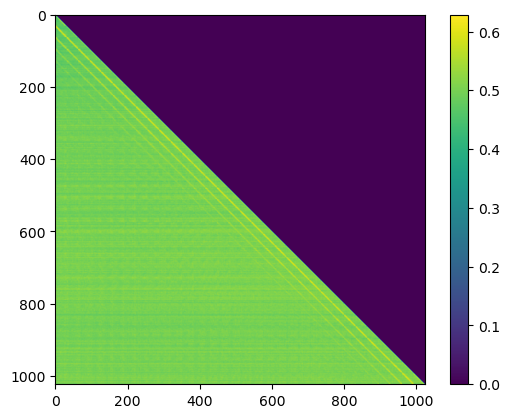

In [51]:
Phi = net.lre.Phi.detach().numpy()
plt.imshow(Phi)
plt.colorbar()

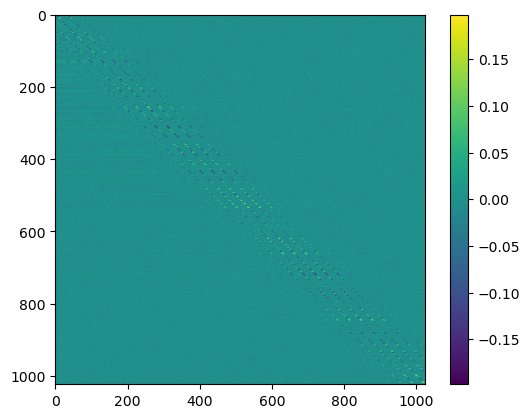

In [52]:
B = net.lre.B.weight.detach().numpy()
plt.imshow(B)
plt.colorbar()

9752


/var/folders/xy/7m07k3417w76kc7zq5jpq3500000gn/T/ipykernel_15758/2798121585.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f = net.l(torch.tensor(x).unsqueeze(-1)).squeeze(-1).detach()[0]


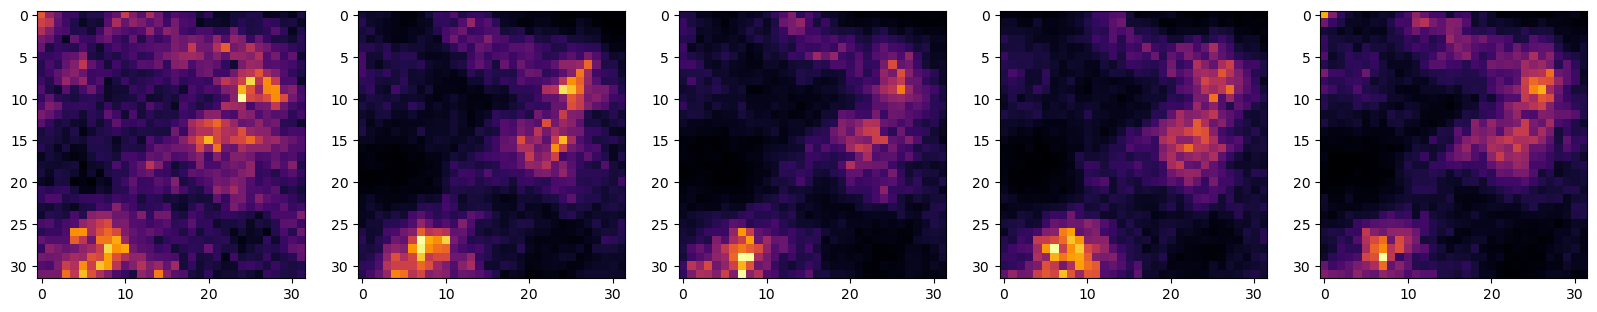

In [100]:
Cov = Cov.double()
i = np.random.randint(len(samples))
print(i)
x = torch.tensor(samples[i]['x']).view(-1, N)
y = torch.tensor(samples[i]['y']).view(-1, N)
f = net.l(torch.tensor(x).unsqueeze(-1)).squeeze(-1).detach()[0]

#print(f.shape)

draws = net.lre.get_samples(4, f, cov = Cov, gamma = 1).view(-1, Npix, Npix)

plt.figure(figsize=(20, 5))
plt.subplot(1,5,1)
plt.imshow(x.view(Npix,Npix), cmap='inferno')
for i in range(4):
    plt.subplot(1, 5, i+2)
    plt.imshow(np.exp(draws[i]), cmap='inferno')